In [3]:
import torch

A = torch.ones((2, 5, 4))
A.shape

torch.Size([2, 5, 4])

In [4]:
A.sum(axis=0).shape

torch.Size([5, 4])

In [5]:
A.sum(axis=1, keepdim=True).shape

torch.Size([2, 1, 4])

In [6]:
x = torch.arange(4.)
print(x)

x.requires_grad_(True)
print(x.grad)

y = 2 * torch.dot(x, x)
print(y)

y.backward()
print(x.grad)

x.grad == 4 * x

tensor([0., 1., 2., 3.])
None
tensor(28., grad_fn=<MulBackward0>)
tensor([ 0.,  4.,  8., 12.])


tensor([True, True, True, True])

In [7]:
x.grad.zero_()

y = x.sum()

y.backward()
x.grad

tensor([1., 1., 1., 1.])

In [8]:
# 深度学习中，目的不是计算微分矩阵，而是批量中每个样本单独计算的偏导数之和

x.grad.zero_()
y = x * x
y.sum().backward()
x.grad

tensor([0., 2., 4., 6.])

In [9]:
# 将某些计算移动到记录的计算图之外

x.grad.zero_()
y = x * x
u = y.detach() 
# 将当前张量从计算图中分离出来，使其不再与前一步的计算有关联
# 这个时候u相对于当前的计算图就是一个常数了
# 所以下面的x.grad就等于u了
z = u * x


z.sum().backward()
x.grad == u

tensor([True, True, True, True])

In [10]:
# 即使构建函数的计算图需要通过python控制流(条件、循环或函数调用)，仍然可以计算得到的变量的梯度

def f(a):
    b = a * 2
    while(b.norm() < 1000):
        b = b * 2
    if b.sum() > 0:
        c = b
    else:
        c = 100 * b
    return c


a = torch.randn(size=(), requires_grad=True)
d = f(a)
d.backward()

a.grad

tensor(409600.)

#### 线性回归

In [11]:
# 从零开始实现线性回归

import random
import torch
import matplotlib.pyplot as plt
import numpy as np

In [12]:
# 直接构造一个带有噪声的人造数据集

def synthetic_data(w, b, num_examples):
    ''' 
    生成Y = Wx + b + noise
    '''
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.3
features, labels = synthetic_data(true_w, true_b, 1000)
features.shape, labels.shape

(torch.Size([1000, 2]), torch.Size([1000, 1]))

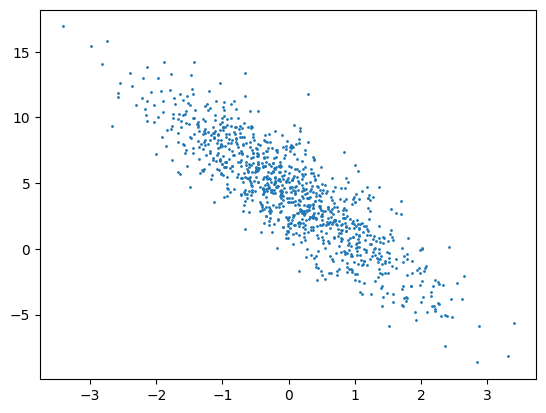

In [13]:
plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), 1)

In [14]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices) # 打乱indices，进行随机读取样本
    
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i: min(i + batch_size, num_examples)])
        # 注意上面的min函数，防止indexerror
        # 与此同时，最后一个batch中的样本个数可能没有batch_size这么多，不过只会“调小学习率”，所以问题不太大
        yield features[batch_indices], labels[batch_indices]
        
batch_size = 10
# for X, y in data_iter(batch_size, features, labels):
#     print(f'{X} \n {y}')
#     break

# 初始化模型函数
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

# 线性回归模型
def linreg(X, w, b):
    return torch.matmul(X, w) + b


def squared_loss(y_hat, y):
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2 # 注意reshape，防止广播导致计算过贵


def sgd(params, lr, batch_size):
    '''小批量随机梯度下降'''
    with torch.no_grad(): # 更新的时候不要梯度计算
        # 在这个参数更新过程中，我们只是在对参数进行简单的算术操作（即从参数中减去一个值），这个操作不需要反向传播，也不需要记录操作历史
        for param in params:
            param -= lr * param.grad / batch_size # 注意这个时候对整个批量作均值
            param.grad.zero_()



In [15]:
lr = 0.03
num_epochs = 3 # 将数据扫三遍
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)
        l.sum().backward()
        
        sgd([w, b], lr, batch_size)
    
    # 此处只是评估性能，所以不用计算梯度
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch{epoch + 1}-- loss{float(train_l.mean())}')  
        



epoch1-- loss0.041724205017089844
epoch2-- loss0.00014583727170247585
epoch3-- loss4.9781447160057724e-05


In [16]:
# 比较真实参数和学习得到参数
true_w - w.reshape(true_w.shape), true_b - b

(tensor([ 0.0004, -0.0006], grad_fn=<SubBackward0>),
 tensor([8.7738e-05], grad_fn=<RsubBackward1>))

In [17]:
# 简洁实现

import numpy as np
import torch
from torch.utils import data 

# true_w = torch.tensor([2, -4.3])
# true_b = 4.3
# features, labels = torch.synthetic_data


def load_array(data_arrays, batch_size, is_train=True):
    '''构造一个torch数据迭代器'''
    dataset = data.TensorDataset(*data_arrays)
    # 使用Loader这个函数来进行随机挑选样本
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 10
data_iter = load_array((features, labels), batch_size)

next(iter(data_iter))


[tensor([[ 0.6887, -0.8977],
         [ 1.4739,  0.3339],
         [ 0.1703, -1.0710],
         [-0.3546, -0.3174],
         [-1.4523, -0.9220],
         [ 0.4762,  0.9557],
         [-0.8396,  0.5938],
         [-0.5761, -1.0435],
         [ 0.2528,  0.2737],
         [ 0.1870, -1.1307]]),
 tensor([[8.7149],
         [6.1144],
         [8.2855],
         [4.6682],
         [4.5172],
         [2.0006],
         [0.5993],
         [6.7052],
         [3.8924],
         [8.5346]])]

In [18]:
from torch import nn
net = nn.Sequential(nn.Linear(2, 1))

net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

loss = nn.MSELoss()

trainer = torch.optim.SGD(net.parameters(), lr=0.03)

In [19]:
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X), y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
        
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')

epoch 1, loss 0.000252
epoch 2, loss 0.000099
epoch 3, loss 0.000099


### Foftmax回归
其实softmax是用于分类问题的
* 回归估计一个连续值
    * 单连续数值输出
    * 自然区间R
    * 跟真实值的区别作为损失
* 分类预测一个离散类别
    * 通常多个输出
    * 输出i是预测第i类的置信度

#### 从回归到多类分类
* 均方损失
    * 对类别进行一位有效编码
    $$
    y = [y_1, y_2, ..., y_n]^T, y_i = 
    \begin{cases}
    1, if i = y\\
    0, otherwise
    \end{cases}
    $$
    * 使用均方损失训练
    * 最大值作为预测
    $$
    \hat{y} = argmax_i o_i
    $$

* 无校验比例
    * 对类别进行一位有效编码
    * 最大值作为预测
    * 需要更置信的识别正确类（大余量）$o_y - o_i \ge \delta(y, i)$

* 校验比例
    * 输出匹配概率（非负，和为1）
    $$
    \hat{y} = softmax(o)\\
    \hat{y}_i = \frac{exp(o_i)}{\Sigma_k exp(o_k)}
    $$
    * 概率y和$\hat{y}$的区别作为损失

* Softmax和交叉熵损失
    * 交叉熵常用来衡量两个概率的区别$H(p, q) = \Sigma_i -p_i log(q_i)$
    * 将其作为损失$l(y, \hat{y}) = \Sigma_i y_i log\hat{y}_i = -log\hat{y}_y$
    * 其梯度是真实概率和预测概率的区别$\partial_{o_i} l(y, \hat{y}) = softmax(o)_i - y_i$

#### 损失函数
* L2 Loss均方损失
    * $l(y, y') = \frac{1}{2} (y - y')^2$
* L1 Loss绝对值损失
    * $l(y, y') = |y - y'|$
* Huber's Robust Loss
    $$
    l(y, y') = 
    \begin{cases}
    |y - y'| - \frac{1}{2}, if |y - y'| \gt 1\\
    \frac{1}{2} (y - y')^2, otherwise
    \end{cases}
    $$
    

#### 图像分类数据集

使用MINST的复杂版本Fashion-MNIST




In [20]:
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l

d2l.use_svg_display()

In [21]:
# 通过框架的内置函数直接将fashion-MINST数据集下载并读取到内存中

trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(
    root='./data/',
    train=True,
    transform=trans,
    download=False
)
minst_test = torchvision.datasets.FashionMNIST(
    root='./data',
    train=False,
    transform=trans,
    download=False
)

len(mnist_train), len(minst_test)

(60000, 10000)

In [22]:
mnist_train[0][0].shape

torch.Size([1, 28, 28])

In [23]:
def get_fashion_mnist_labels(labels):
    '''返回Fashion-MNIST数据集的文本标签'''
    text_labels = [
        't-shirts', 'trouser', 'pullover', 
        'dress', 'coat', 'sandal', 'shirt', 
        'sneaker', 'bag', 'ankle boot'
    ]
    return [text_labels[int(i)] for i in labels]

def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    '''plot a list of images'''
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # 图片张量
            ax.imshow(img.numpy())
        else:
            # PLT照片
            ax.imshow(img)
    

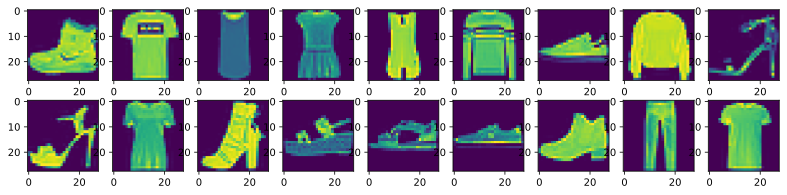

In [24]:
X, y = next(iter(data.DataLoader(mnist_train, batch_size=18)))
show_images(X.reshape(18, 28, 28), 2, 9, titles=get_fashion_mnist_labels(y))

In [25]:
# 读取小批量数据，大小为batch_size

batch_size = 256
def get_dataloader_workers():
    '''使用4个进程来读取数据'''
    return 4

train_iter = data.DataLoader(
    mnist_train, batch_size, shuffle=True,
    num_workers=get_dataloader_workers()
    # 这个就是在后台开num个进程办这个事情
)

timer = d2l.Timer()
for X, y in train_iter:
    continue

f'{timer.stop(): .2f} sec' # 读取数据的时间是一个常见的性能瓶颈

' 0.41 sec'

In [26]:
def load_data_fashion_mnist(batch_size, resize=None):
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize)) # 如果有更换大小的操作，放在最开始进行
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root='./data',
        train=True,
        transform=trans,
        download=False
    )
    mnist_test = torchvision.datasets.FashionMNIST(
        root='./data',
        train=False,
        transform=trans,
        download=False
    )
    
    return (
        data.DataLoader(
            mnist_train, batch_size, shuffle=True, num_workers=get_dataloader_workers()
        ),
        data.DataLoader(
            mnist_test, batch_size, shuffle=False, num_workers=get_dataloader_workers()
        )
    )

In [27]:
from IPython import display
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

In [28]:
num_inputs = 28 * 28 # 输入维度是1 * 28 * 28
num_outputs = 10 # 一共有10个类别

W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

W.shape, b.shape

(torch.Size([784, 10]), torch.Size([10]))

In [29]:
# 这一段是一个练手，给定一个矩阵X，可以对所有元素求和

X = torch.tensor([[1., 2., 3.], [4., 5., 6.]])
X.sum(dim=0, keepdim=True), X.sum(dim=1, keepdim=True)

(tensor([[5., 7., 9.]]),
 tensor([[ 6.],
         [15.]]))

实现Softmax:
$$
softmax(X)_{ij} = \frac{exp(X_{ij})}{\Sigma_k exp(X_{ik})}
$$

In [30]:
# 实现Softmax
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(dim=1, keepdim=True) # 这里是对每一行进行求和
    return X_exp / partition # 注意这里使用了广播机制

In [31]:
# 这里验证一下

X = torch.normal(0, 1, (2, 5))
X_prob = softmax(X)
X_prob, X_prob.sum(dim=1, keepdim=True)

(tensor([[0.3347, 0.1025, 0.0940, 0.2211, 0.2478],
         [0.4102, 0.1199, 0.1247, 0.2289, 0.1164]]),
 tensor([[1.],
         [1.]]))

In [32]:
# 实现softmax回归模型
def net(X):
    return softmax( torch.matmul(X.reshape((-1, W.shape[0])), W) + b ) 
    # 注意前面将X变形为能和W进行矩阵乘法形状

In [33]:
# 创建一个数据y_hat，其中包含2个样本在3个类别的预测概率，使用y作为y_hat中概率的索引
y = torch.tensor([0, 2])
y_hat = torch.tensor([
    [0.1, 0.3, 0.6],
    [0.3, 0.2, 0.5]
])
y_hat[[0, 1], y] 
# 注意这个地方，如果前后都是两个列表，需要两个列表的len相同，然后索引就是俩取第一个作为下标，俩都取第二个作为下标这样子

tensor([0.1000, 0.5000])

In [34]:
# 这里实现交叉熵损失函数

def cross_entropy(y_hat, y):
    return -torch.log(y_hat[range(len(y_hat)), y])

cross_entropy(y_hat, y)

tensor([2.3026, 0.6931])

In [35]:
# 将预测类别与真实y进行比较

def accuracy(y_hat, y):
    '''计算预测正确的数量'''
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1) # 这个表示的是取到每一个样本预测最大概率的类别
        
    cmp = y_hat.type(y.dtype) == y
    # 注意，上面这一行是将y_hat中的type转换为和y中一致，之后通过逻辑运算符得到一个布尔张量
    return float(cmp.type(y.dtype).sum())

accuracy(y_hat, y) / len(y)

0.5

In [36]:
# 写一个可以评估在任意模型net的准确率
class Accumulator:
    '''在n个变量上叠加'''
    def __init__(self, n) -> None:
        self.data = [0.] * n
    
    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]
        
    def reset(self):
        self.data = [0.] * len(self.data)
        
    def __getitem__(self, idx):
        return self.data[idx]


def evaluate_accuracy(net, data_iter):
    '''计算在指定数据集上模型的精度'''
    if isinstance(net, torch.nn.Module):
        net.eval() # 将模型设置为评估模式
    metrix = Accumulator(2) # 正确1预测数，预测总数
    for X, y in data_iter:
        metrix.add(accuracy(net(X), y), y.numel())
    return metrix[0] / metrix[1]


evaluate_accuracy(net, test_iter)

0.1237

In [37]:
def train_epoch_ch3(net, train_iter, loss, updater):
    if isinstance(net, torch.nn.Module):
        net.train() # 开启训练模式
    metric = Accumulator(3)
    
    for X, y in train_iter:
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            updater.step()
            metric.add(
                float(l) * len(y), accuracy(y_hat, y), y.size().numel()
            )
        else:
            l.sum().backward()
            updater(X.shape[0])
            metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]

In [38]:
# 实现一个辅助函数，做一个动画
class Animator:
    '''在动画中绘制数据'''
    def __init__(
        self, xlabel=None, ylabel=None, legend=None, 
        xlim=None, ylim=None, xscale='linear', yscale='linear',
        fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1, figsize=(3.5, 2.5)
    ):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend
        )
        self.X, self.Y, self.fmts = None, None, fmts
        
    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [39]:
# 训练函数

def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):
    animator = Animator(
        xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
        legend=['train loss', 'train acc', 'test acc']
    )
    
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc, ))
    train_loss, train_acc = train_metrics
        

In [40]:
# 小批量随机梯度下降来优化模型的损失函数

lr = 0.1

def updater(batch_size):
    return d2l.sgd([W, b], lr, batch_size)

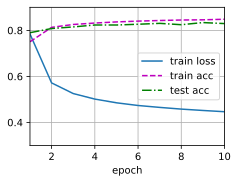

In [41]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

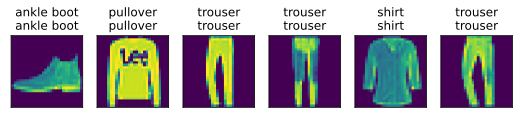

In [42]:
def predict_ch3(net, test_iter, n=6):
    '''预测标签'''
    for X, y in test_iter:
        break
    trues = d2l.get_fashion_mnist_labels(y)
    preds =d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true + '\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(X[0: n].reshape((n, 28, 28)), 1, n, titles=titles[0: n])
    
predict_ch3(net, test_iter)

#### 简洁实现

In [43]:
# 直接通过深度学习模型的高级API能够实现softmax回归

import torch
from torch import nn
from d2l import torch as d2l

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

In [44]:
# torch不会隐式地调整输入的形状，因此需要定义flatten展平层，在线性层之前调整网络输入的形状

net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=10, bias=True)
)

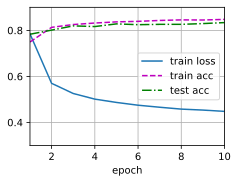

In [45]:
# 依然使用交叉熵损失
# 向交叉熵损失中传递未归一化的预测，并同时计算softmax及其对数
loss = nn.CrossEntropyLoss()

# 使用学习率为0.1的小批量随机梯度下降作为优化算法
trainer = torch.optim.SGD(net.parameters(), lr=0.1)

num_epoch =10
train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

## 感知机 Perceptron
给定输入x，权重w和偏移b，感知机输出：
$$
o = \sigma(<w, x> + b), \sigma(x) = 
\begin{cases}
    1, if x > 0\\
    -1, otherwise
\end{cases}
$$
**二分类**


* 训练感知机——等价于使用batch_size=1的梯度下降，使用损失函数：
$$
\mathcal{l}(y, x, w) = max(0, -y<w, x>)
$$

```
initialize w = 0, b = 0
repeat
    if y[i](<w, x[i]> + b) then
        w = w + y[i]x[i]
        b = b + y[i]
    end if
until all classified correctly
```

* 收敛定理
    * 数据在半径r内
    * 余量rho分类两类
        $$
            y(x^T w + b) \ge \rho
        $$
        对于$||w||^2 + b^2 \le 1$
    * 感知机保证在$\frac{r^2 + 1}{\rho^2}$步后收敛

* XOR问题
感知机不能拟合XOR函数，只能产生线性分割面(需要核函数用核支持向量机)————导致第一次AI寒冬

## 多层感知机MLP
*  学习XOR——使用两层感知机

* 单隐藏层——隐藏层大小是一个超参数
#### 单分类
* 输入$x \in R^n$
* 隐藏层$W_1 \in R^{m \times n}, b_1 \in R^m$
* 输出层$w_2 \in R^m, b_2 \in R$
    $$
    h = \sigma(W_1 x + b)\\
    o = w_2^Th + b_2
    $$
    其中sigma是按元素的激活函数
![Hidden Layer](./imgs/hidden-layer.png)

* 为什么需要激活函数
如果没有激活函数，12, 23层整体作用结果是一个线性函数，那整体还是一个线性模型，和一层没有区别好的吧


### 激活函数
* Sigmoid激活函数
    * 将输入投影到(1, 0)，是一个软的激活函数
    $$
    \sigma(x) = 
    \begin{cases}
    1, if~x > 0\\
    0, other wise
    \end{cases}
    $$
    
    $$
    sigmoid(x) = \frac{1}{1 + exp(-x)}
    $$
    ![sigmoid](./imgs/sigmoid.png)

* tanh激活函数
    * 将输入投影到(-1, 1)
    $$
    tanh(x) = \frac{1 - exp(-2x)}{1 + exp(-2x)}
    $$
    ![tanh](./imgs/tanh.png)
* ReLU激活函数
    * ReLU: rectified linear unit
    $$
    ReLU(x) = max(x, 0)
    $$
    ![ReLU](./imgs/ReLU.png)

**注意，指数运算是很贵的，算一次指数几乎相当于**

#### 多分类
$y_1, y_2, ..., y_k = softmax(o_1, o_2, ..., o_k)$
加个隐藏层然后再做softmax回归
* 输入$x \in R^n$
* 隐藏层$W_1 \in R^{m \times n}, b_1 \in R^m$
* 输出层$W_2 \in R^{m \times k}, b_2 \in R^k$
    $$
    h = \sigma(W_1x + b_1)\\
    o = W_2^Th + b_2\\
    y = softmax(o)
    $$

可以做多隐藏层，超参数：隐藏层数&每层隐藏层的大小

注意提取特征需要慢慢压缩


## MLP代码实现
#### 手搓

In [46]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

In [47]:
# 实现一个具有单隐藏层的MLP，包含256个隐藏单元

num_inputs, num_outputs, num_hiddens = 28 * 28, 10, 256

W1 = nn.Parameter(
    torch.randn(num_inputs,num_hiddens, requires_grad=True)
)
b1 = nn.Parameter(
    torch.zeros(num_hiddens, requires_grad=True)
)
W2 = nn.Parameter(
    torch.randn(num_hiddens, num_outputs, requires_grad=True)
)
b2 = nn.Parameter(
    torch.zeros(num_outputs, requires_grad=True)
)

params = [W1, b1, W2, b2]

In [48]:
# 实现relu几乎函数
def relu(X):
    a = torch.zeros_like(X)
    return torch.max(X, a)

In [49]:
# 实现模型
def net(X):
    X = X.reshape((-1, num_inputs))
    H = relu(X @ W1 + b1)
    return (H @ W2 + b2)

loss = nn.CrossEntropyLoss()

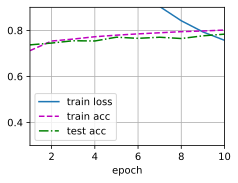

In [50]:
# 训练过程同前面的spftmax回归的训练过程

num_epochs, lr = 10, 0.1
updater = torch.optim.SGD(params, lr=lr)

train_ch3(net, train_iter, test_iter, loss, num_epochs, updater)

# 这里目前的结果是有问题的，不知为何d2l中没有train_ch3这个函数

#### 简洁实现

In [51]:
import torch
from torch import nn
from d2l import torch as d2l

In [52]:
net = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 256),
    nn.ReLU(),
    nn.Linear(256, 10)
)

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)
        
net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=10, bias=True)
)

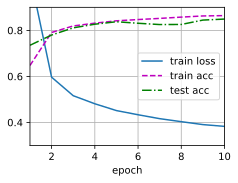

In [53]:
batch_size, lr, num_epochs = 256, 0.1, 10
loss = nn.CrossEntropyLoss()
trainer = torch.optim.SGD(net.parameters(), lr=lr)
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

# 这个下面的结果是正常的

# MLP比SVM使用的更多，因为MLP转其他地方相对容易，但是SVM需要他调整很多东西

## CH11 模型选择+过拟合欠拟合


### 模型选择

#### 训练误差&泛化误差

* 训练误差：模型在训练数据上的误差
* 范化误差：模型在新数据上的误差
* eg：根据模考成绩来预测未来考试分数
    * 过去的考试考的好——训练误差
    * 未来考试如何——泛化误差

#### 验证数据集&测试数据集
* 验证数据集：一个拿来评估模型好坏的数据集
    * 例如拿出50%的训练数据
    * 不要跟训练数据混在一起
* 测试数据集：只用一次的数据集
    * 未来的考试
    * 出价的房子的实际成交价
    * 用在Kaggle私有排行榜中的数据集
一定不要根据测试数据集的结果来调自己的参数

#### K折交叉验证
* 在没有足够多的数据时使用
* 算法:
    * 将训练数据分割成K块
    * 每一次使用第i块作为验证数据集，其余的作为训练数据集
    * 报告K个验证集误差的平均
* 常用K=5或10

### 过拟合&欠拟合
overfitting & underfitting
![underfitting & overfitting](./imgs/fitting.png)

#### 模型容量
* 拟合各种函数的能力
* 低容量的模型难以拟合训练数据
* 高容量的模型可以记住所有训练数据

##### 估计模型容量
* 难以在不同种类的算法之间比较
    * 树模型&神经网络
* 给定一个模型种类，将有两个主要因素
    * 参数的个数
    * 参数值的选择范围

#### VC维
* 统计学习理论的核心思想
* 对于一个分类模型，VC等于一个最大的数据集的大小，不管如何给定标号，都存在一个模型来对它进行完美分类

##### 用途
* 提供为什么模型好的理论依据
    * 可以衡量训练误差和泛化误差之间的间隔
* 但深度学习中很少使用 
    * 衡量不是很准确
    * 计算深度学习模型的VC维很困难

#### 数据复杂度
* 多个重要因素
    * 样本个数
    * 每个样本的元素个数
    * 时间、空间结构
    * 多样性

### 构造现象

In [54]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

In [55]:
max_degree = 20
n_train, n_test = 100, 100
true_w = np.zeros(max_degree)
true_w[0: 4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
ploy_features = np.power(features, np.arange(max_degree).reshape(1, -1))

for i in range(max_degree):
    ploy_features[:, i] /= math.gamma(i + 1)

labels = np.dot(ploy_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)


In [56]:
true_w, features, ploy_features, labels = [
    torch.tensor(x, dtype=torch.float32)
    for x in [true_w, features, ploy_features, labels]
]

features[:2], ploy_features[:2], labels[:2] 

(tensor([[-0.9253],
         [ 0.2122]]),
 tensor([[ 1.0000e+00, -9.2529e-01,  4.2808e-01, -1.3203e-01,  3.0542e-02,
          -5.6521e-03,  8.7165e-04, -1.1522e-04,  1.3326e-05, -1.3701e-06,
           1.2677e-07, -1.0664e-08,  8.2226e-10, -5.8526e-11,  3.8681e-12,
          -2.3861e-13,  1.3799e-14, -7.5106e-16,  3.8608e-17, -1.8802e-18],
         [ 1.0000e+00,  2.1222e-01,  2.2519e-02,  1.5930e-03,  8.4517e-05,
           3.5873e-06,  1.2688e-07,  3.8467e-09,  1.0205e-10,  2.4062e-12,
           5.1066e-14,  9.8520e-16,  1.7423e-17,  2.8443e-19,  4.3116e-21,
           6.1001e-23,  8.0911e-25,  1.0101e-26,  1.1909e-28,  1.3301e-30]]),
 tensor([1.5329, 5.1950]))

In [57]:
def evaluate_loss(net, data_iter, loss):
    '''评估给定数据集上模型的损失'''
    
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [60]:
def train(train_features, test_features, train_labels, test_labels, num_epochs=400):
    loss = nn.MSELoss()
    input_shape = train_features.shape[-1]
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array(
        (train_features, train_labels.reshape(-1, 1)), batch_size
    )
    test_iter = d2l.load_array(
        (test_features, test_labels.reshape(-1,1)), batch_size
    )
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(
        xlabel='epoch', ylabel='loss', yscale='log',
        xlim=[1, num_epochs], ylim=[1e-3, 1e2],
        legend=['train', 'test']
    )
    
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(
                epoch + 1,
                (evaluate_loss(net, train_iter, loss), evaluate_loss(net, test_iter, loss))
            )
    print('weight: ', net[0].weight.data.numpy())

weight:  [[ 5.000881   1.3873937 -3.4391878  5.0314703]]


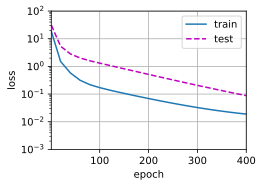

In [61]:
train(
    ploy_features[:n_train, :4],
    ploy_features[n_train:, :4],
    labels[:n_train],
    labels[n_train:]
)

## 权重衰退 weight decay

#### 使用均方范数作为硬性限制
* 通过限制参数值的选择范围来控制模型容量
    $min~\mathcal{l}(w, b)~subject~to~||w||^2 \le \theta$
    * 通常不限制偏移b（是否限制差不多）
    * 小的$\theta$意味着更强的正则项

#### 使用均方范数作为柔性限制
* 对每个$\theta$，都可以找到$\lambda$是之前的目标函数等价于：
    $$
    min~l(w, b) + \frac{\lambda}{2} ||w||^2
    $$
    * 后面的项叫做penalty惩罚项
    * 可以通过拉格朗日乘子来证明

* 超参数$\lambda$控制了正则项的重要程度
    * $\theta = 0$：无作用
    * $\lambda \rightarrow \inf, w* \rightarrow 0$
    ![penalty的引入会引导最优解向原点移动](./imgs/penalty.png)
#### 参数更新法则——为什么权重衰退
* 计算梯度
$$
\frac{\partial}{\partial w}\big( l(w, b) + \frac{\lambda}{2}||w||^2 \big)
= 
\frac{\partial l(w, b)}{\partial w} + \lambda w
$$
* 时间t更新梯度
$$
w_{t + 1} = (1 - \eta \lambda)w_t - \eta \frac{\partial l(w_t, b)}{\partial w_t}
$$
    
* 通常$\eta \lambda \lt 1$，在深度学习中称作权重衰退

### 实现



In [62]:
# 权重衰退是广泛使用的正则化技术之一
import torch
from torch import nn
from d2l import torch as d2l

# 生成人工数据集
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones((num_inputs, 1)) + 0.01, 0.05
train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)

In [63]:
# 初始化模型参数
def init_params():
    w = torch.normal(0, 1, size=(num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

# 定义L2范数penalty
def L2_penalty(w):
    return torch.sum(w.pow(2)) / 2


In [64]:
def train(lambd):
    w, b = init_params()
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    num_epochs, lr = 100, 0.003
    animator = d2l.Animator(
        xlabel='epochs', ylabel='loss', yscale='log',
        xlim=[5, num_epochs], legend=['train', 'test']
    )
    
    for epoch in range(num_epochs):
        for X, y in train_iter:
            # with torch.enable_grad():
            l = loss(net(X), y) + lambd * L2_penalty(w)
            l.sum().backward()
            d2l.sgd([w, b], lr, batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(
                epoch + 1,
                (d2l.evaluate_loss(net, train_iter, loss), d2l.evaluate_loss(net, test_iter, loss))
            )
    print('w的L2范数是：', torch.norm(w).item())

w的L2范数是： 13.796527862548828


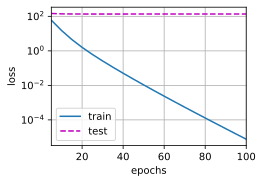

In [65]:
# 忽略正则项直接训练

train(lambd=0)

# 下面的结果是，test_error几乎没有变化，这是非常严重的过拟合

w的L2范数是： 3.0837228298187256


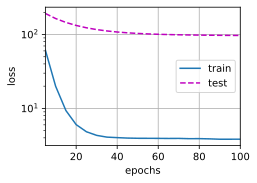

In [66]:
# 使用权重衰减
train(lambd=3)

w的L2范数是： 1.3861548900604248


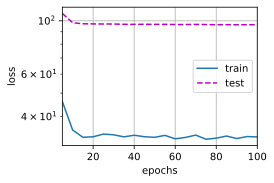

In [67]:
train(lambd=20)

w的L2范数是： 13.95821762084961


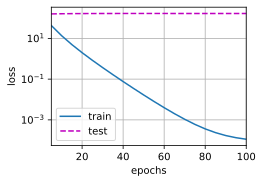

In [68]:
train(lambd=1e-2)

## 丢弃法Dropout
#### 动机
* 一个好的模型需要对输入数据的扰动鲁棒
    * 使用有噪音的数据等价于Tikhonov正则
    * 丢弃法：在层之间加噪音

#### 无偏差的加入噪音
* 对x加入噪音得到x'，希望$E[x'] = x$
* 丢弃法对每个元素进行如下扰动：
$$
x_i' = 
\begin{cases}
0, with~probablity~p\\
\frac{x_i}{1 - p}, otherwise
\end{cases}
$$

#### 使用
* 通常将dropout作用在隐藏全连接层的输出上
$$
h = \sigma (W_1x + b_1)\\
h' = dropout(h)\\
o = W_2h' + b_2\\
y = softmax(o)
$$
![dropout](./imgs/dropout.png)

#### 推理中的丢弃法
* 正则项只在训练中使用：他们影响模型参数的更新
* 在推理过程中，丢弃法直接返回输入$h = dropout(h)$
    * 这样也能保真如果确定性的输出

### 代码实现



In [74]:
import torch
from torch import nn
from d2l import torch as d2l

def dropout_layer(X, dropout):
    assert 0 <= dropout <= 1
    if dropout == 1:
        return torch.zeros_like(X)
    if dropout == 0:
        return X
    mask = (torch.Tensor(X.shape).uniform_(0, 1) > dropout).float()
    return mask * X / (1. - dropout)
    # 注意不使用X[mask] = 0，因为作乘法远远比选元素来的快


In [75]:
# 测试一下

X = torch.arange(16, dtype=torch.float32).reshape((2, 8))

print(X)
print(dropout_layer(X, 0.))
print(dropout_layer(X, 0.5))
print(dropout_layer(X, 1.))

tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.,  2.,  4.,  6.,  0., 10., 12., 14.],
        [16.,  0.,  0., 22.,  0., 26.,  0., 30.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])


In [79]:
# 定义具有两个hidden layer的MLP，每个隐藏层包含256个单元

num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256
dropout1, dropout2 = 0.2, 0.5

class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs, 
                 num_hiddens1, num_hiddens2, 
                 is_training=True):
        super(Net, self).__init__()
        self.num_inputs = num_inputs
        self.training = is_training
        self.lin1 = nn.Linear(num_inputs, num_hiddens1)
        self.lin2 = nn.Linear(num_hiddens1, num_hiddens2)
        self.lin3 = nn.Linear(num_hiddens2, num_outputs)
        self.relu = nn.ReLU()
        
    def forward(self, X):
        H1 = self.relu(
            self.lin1(X.reshape((-1, num_inputs)))
        )
        if self.training == True:
            H1 = dropout_layer(H1, dropout1)
        H2 = self.relu(self.lin2(H1))
        if self.training == True:
            H2 = dropout_layer(H2, dropout2)
        return self.lin3(H2)
        
        
net = Net(num_inputs, num_outputs, num_hiddens1, num_hiddens2)

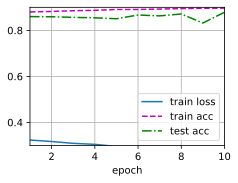

In [81]:
num_epochs, lr, batch_size = 10, 0.5, 256
loss = nn.CrossEntropyLoss()
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
trainer = torch.optim.SGD(net.parameters(), lr=lr)
train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

#### 简洁实现


In [83]:
net = nn.Sequential(
    nn.Flatten(), # 记得使用Flatten进行拉平，现在还不是CNN
    nn.Linear(784, 256),
    nn.ReLU(),
    nn.Dropout(dropout1),
    nn.Linear(256, 256),
    nn.ReLU(),
    nn.Dropout(dropout2),
    nn.Linear(256, 10)
)

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.2, inplace=False)
  (4): Linear(in_features=256, out_features=256, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.5, inplace=False)
  (7): Linear(in_features=256, out_features=10, bias=True)
)

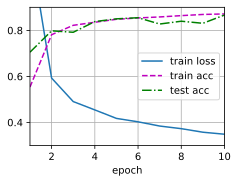

In [84]:
trainer = torch.optim.SGD(net.parameters(), lr=lr)
train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

## 数值稳定性+模型初始化&激活函数

### 数值稳定性

#### 神经网络的梯度
* 对于一个d层的神经网络：
    $$
    h_t = f_t(h^{t - 1})~and~y = l \circ f_d \circ ... \circ f_1(x)
    $$
* 计算损失l关于参数$W_t$的梯度
$$
\frac{\partial l}{\partial W^t} = \frac{\partial l}{\partial h^d} \frac{\partial h^d}{\partial h^{d -1}}...\frac{\partial h^{t + 1}}{\partial h^t} \frac{\partial h^t}{\partial W^t}
$$
注：向量关于向量的导数，是矩阵，所以中间有d-t次的矩阵乘法

#### 数值稳定性的常见问题
* 梯度爆炸
    * 值超出值域inf
        * 对于16位浮点数尤为严重(6e-5 ~ 6e4)
    * 对学习率敏感
        * 如果学习率太大 >> 大参数值 >> 更大的梯度
        * 如果学习率太小 >> 训练无进展
        * 可能需要在训练过程中不断调整学习率
* 梯度消失
    * 梯度值变成0
        * 对16位浮点数尤为严重
    * 训练没有进展
        * 不管如何选择学习率
    * 对于底部层尤为严重
        * 仅仅顶部层训练的较好
        * 无法让神经网络更深


### 让训练更加稳定
* 目标：让梯度值在合理的范围内
    * eg [1e-6, 1e3]
* 将乘法变加法
    * ResNet, LSTM
* 归一化
    * 梯度归一化，梯度裁减
* 合理的权重初始和激活函数

方式
* 让每层的方差是一个常数
    * 将每层的输出和梯度都看作是随机变量
    * 让他们的均值和方差都保持一致
正向：
$$
E[h_i^t] = 0\\
Var[h_i^t] = a
$$
反向：
$$
E[\frac{\partial l}{\partial h_i^t}] = 0\\
Var[\frac{\partial l}{\partial h_i^t}] = b, \forall i, t
$$
#### 模型初始化
##### 权重初始化
* 在合理值区间里随机初始参数
* 训练开始的时候更容易有数值不稳定
    * 原理最优解的地方村是函数表面可能很复杂
    * 最优解附近表面可能会比较平
* 使用N(0, 0.01)来初始可能对小网络没问题，但不能保证深度神经网络

#### 激活函数
##### 检查常用激活函数
* 使用Taylor展开，使激活函数在0附近趋近于`0 + x`的形式

## Kaggle比赛：预测房价

In [2]:
import hashlib
import os
import tarfile
import zipfile
import requests

DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'
 
def download(name, cache_dir=os.path.join('data', 'house_price')):
    '''下载一个DATA_HUB中的文件，返回本地文件名'''
    assert name in DATA_HUB, f'{name} not in {DATA_HUB}'
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # 命中缓存
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

def download_extract(name, folder=None):  #@save
    """下载并解压zip/tar文件"""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只有zip/tar文件可以被解压缩'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all():  #@save
    """下载DATA_HUB中的所有文件"""
    for name in DATA_HUB:
        download(name)         
    

In [3]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

DATA_HUB['kaggle_house_train'] = (  #@save
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (  #@save
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

train_data.shape, test_data.shape

正在从http://d2l-data.s3-accelerate.amazonaws.com/kaggle_house_pred_train.csv下载data/house_price/kaggle_house_pred_train.csv...
正在从http://d2l-data.s3-accelerate.amazonaws.com/kaggle_house_pred_test.csv下载data/house_price/kaggle_house_pred_test.csv...


((1460, 81), (1459, 80))

In [4]:
train_data.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [7]:
# 第一列是ID，将其从数据集中删除

all_features = pd.concat((train_data.iloc[:, 1: -1], test_data.iloc[:, 1:]))
all_features

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1455,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
1456,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal


In [8]:
# 缺失值处理——将所有缺失的值替换为相应特征的平均值，然后将特征标准化
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / x.std()
)
all_features[numeric_features] = all_features[numeric_features].fillna(0)

In [9]:
# 接下来使用One-Hot encoding
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 331)

In [10]:
# 从pandas格式中提取NumPy格式，并将其转换为张量表示
n_train = train_data.shape[0]
train_features = torch.tensor(
    all_features[:n_train].values, dtype=torch.float32
)
test_features = torch.tensor(
    all_features[n_train:].values, dtype=torch.float32
)
train_labels = torch.tensor(
    train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32
)

In [19]:
loss = nn.MSELoss()
in_features = train_features.shape[1]

def get_net():
    return nn.Sequential(nn.Linear(in_features, 1))

In [27]:
# 关心相对误差——使用价格预测的对数来衡量差异

def log_rmse(net, features, labels):
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))
    return rmse.item()

In [28]:
# 训练函数借助Adam优化器


def train(net, train_features, train_labels, 
          test_features, test_labels, num_epochs, 
          learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X) ,y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

In [29]:
# K-fold validation

def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
            
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid


def k_fold(k, X_train, y_train, num_epochs, 
           learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train ,y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, 
                                   learning_rate, weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(
                list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                legend=['train', 'valid'], yscale='log'
            )
        print(f'折{i + 1}，训练log rmse{float(train_ls[-1]):f}, '
              f'验证log rmse{float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

折1，训练log rmse0.170153, 验证log rmse0.156744
折2，训练log rmse0.161914, 验证log rmse0.188185
折3，训练log rmse0.163417, 验证log rmse0.168220
折4，训练log rmse0.167894, 验证log rmse0.154400
折5，训练log rmse0.163262, 验证log rmse0.183086
5-折验证: 平均训练log rmse: 0.165328, 平均验证log rmse: 0.170127


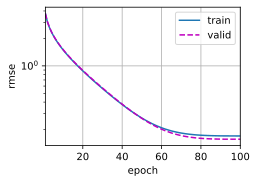

In [30]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')